## Fine Tuning VQA

In [16]:
import os
import json 
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics import BLEUScore
from torchvision import transforms 
from transformers import ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader, random_split 
from torch.nn.functional import cross_entropy
from transformers import BertTokenizer, BertModel, ViTModel, BertConfig, AdamW, ViTConfig
from transformers import BertLMHeadModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
class VQA_RAD_Dataset(Dataset):
    def __init__(self, json_dir, img_dir, transform=None):

        with open(json_dir, 'r') as file:
            self.data = json.load(file)

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data[index]['image_name'])
        question = self.data[index]['question']
        answer = str(self.data[index]['answer'])

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, question, answer

In [ ]:
# Download VQA_RAD Image Folder.zip and VQA_RAD Dataset Public.json from https://osf.io/89kps/
# Load Images into img_dir and json into json_dir. 

image_dir = r"../../Dataset/VQA_RAD Images"
json_dir = r"../../Dataset/VQA_RAD Dataset Public.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = VQA_RAD_Dataset(json_dir=json_dir, img_dir=image_dir, transform=transform)

In [8]:
def custom_collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)  
    questions = list(questions)  
    answers = list(answers)      
    return images, questions, answers


train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")

Number of samples in train set: 1798
Number of samples in test set: 450


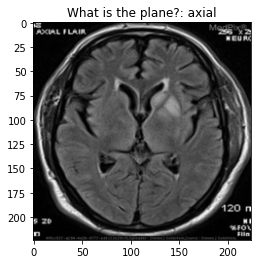

In [9]:
image, question, answer = train_dataset.__getitem__(-1)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{question}: {answer}")
plt.show()

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, bert, vit, answer_decoder_config):
        super(VQAModel, self).__init__()
        
        self.bert = bert
        self.text_encoder = nn.ModuleList(self.bert.encoder.layer[:6])  
        self.multimodal_encoder = nn.ModuleList(self.bert.encoder.layer[6:])  
        self.image_encoder = vit  

        self.answer_decoder = BertLMHeadModel(answer_decoder_config)

    def forward(self, input_ids, attention_mask, images, decoder_input_ids, target_ids=None):
        text_embeddings = self._encode_text(input_ids, attention_mask)
        image_embeddings = self.image_encoder(images).last_hidden_state
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        combined_attention_mask = torch.cat(
            [attention_mask, torch.ones((attention_mask.size(0), image_embeddings.size(1)), device=attention_mask.device)],
            dim=1
        )

        multimodal_embeddings = self._encode_multimodal(combined_embeddings, combined_attention_mask)

        outputs = self.answer_decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=multimodal_embeddings,
            labels=target_ids  
        )

        logits = outputs.logits
        loss = outputs.loss if target_ids is not None else None  

        return {"logits": logits, "loss": loss}

    def _encode_text(self, input_ids, attention_mask):
        text_embeddings = self.bert.embeddings(input_ids=input_ids)
        
        attention_mask_expanded = attention_mask.unsqueeze(1).unsqueeze(2).float()
        attention_mask_expanded = (1.0 - attention_mask_expanded) * -10000.0

        for layer in self.text_encoder:
            text_embeddings = layer(text_embeddings, attention_mask=attention_mask_expanded)[0]
        
        return text_embeddings

    def _encode_multimodal(self, combined_embeddings, combined_attention_mask):
        combined_attention_mask_expanded = combined_attention_mask.unsqueeze(1).unsqueeze(2).float()
        combined_attention_mask_expanded = (1.0 - combined_attention_mask_expanded) * -10000.
        
        for layer in self.multimodal_encoder:
            combined_embeddings = layer(combined_embeddings, attention_mask=combined_attention_mask_expanded)[0]

        return combined_embeddings

In [ ]:
import os
import torch
import torch.optim as optim
from tqdm import tqdm
from transformers import BertTokenizer

def train_vqa_model(model, dataloader, tokenizer, device='cuda', num_epochs=3, learning_rate=1e-5, model_checkpoint_path="vqa_model_checkpoint.pth"):
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    start_epoch = 0
    if os.path.exists(model_checkpoint_path):
        checkpoint = torch.load(model_checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch + 1}")

    model.to(device)
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0

        for images, questions, answers in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):

            images = images.to(device)
            optimizer.zero_grad()

            encoding = tokenizer(questions, padding='max_length', truncation=True, max_length=12, return_tensors='pt')
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            target_ids = tokenizer(answers, padding='max_length', truncation=True, max_length=12, return_tensors='pt')['input_ids'].to(device)
            decoder_input_ids = torch.full((input_ids.size(0), target_ids.size(1)), tokenizer.cls_token_id, device=device)

            outputs = model(input_ids, attention_mask, images, decoder_input_ids, target_ids)
            loss = outputs['loss']  

            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, model_checkpoint_path)
        print(f"Model checkpoint saved at epoch {epoch + 1}")

    print("Training complete.")


In [ ]:
def load_pretrained_models(bert_checkpoint_path, vit_checkpoint_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    bert_config = BertConfig.from_pretrained('bert-base-uncased')
    bert_model = BertModel(bert_config)
    bert_checkpoint = torch.load(bert_checkpoint_path, map_location=device)
    bert_model.load_state_dict(bert_checkpoint)
    bert_model.to(device)
    bert_model.eval()  

    vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
    vit_model = ViTModel(vit_config)
    vit_checkpoint = torch.load(vit_checkpoint_path, map_location=device)
    vit_model.load_state_dict(vit_checkpoint)
    vit_model.to(device)
    vit_model.eval()  

    return bert_model, vit_model


# Load the weights saved into "encoder_checkpoints" dir from pre-training task (main.py) 
# or download the zip containing pretraining weights from https://drive.google.com/drive/folders/1eRLodaMzFyocBVN0_7B0miak76asTEKp?usp=drive_link and save it in a dir with name "encoder_checkpoints"
# Replace the path to the weights below 

bert_checkpoint_path = "../../../encoder_checkpoints/bert_model_checkpoint.pth"
vit_checkpoint_path = "../../../encoder_checkpoints/image_encoder_checkpoint.pth"

bert, vit = load_pretrained_models(bert_checkpoint_path, vit_checkpoint_path, device=device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
answer_decoder_config = BertConfig.from_pretrained('bert-base-uncased')
answer_decoder_config.is_decoder = True
answer_decoder_config.add_cross_attention = True

model = VQAModel(bert, vit, answer_decoder_config).to(device)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

epochs = 8  
metric_history = train_vqa_model(model=model, 
                                 dataloader=train_dataloader, 
                                 tokenizer=tokenizer, 
                                 device=device, 
                                 num_epochs=epochs, 
                                 learning_rate=1e-5, 
                                 model_checkpoint_path="vqa_model_checkpoint.pth")

Resuming training from epoch 9
Training complete.


In [ ]:
import os
import torch
from tqdm import tqdm
from transformers import BertTokenizer
from torchmetrics.text import BLEUScore
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torchvision import transforms

def test_vqa_model(model, dataloader, tokenizer, device='cuda', model_checkpoint_path="vqa_model_checkpoint.pth", display_examples=3):
    torch.cuda.empty_cache()

    if os.path.exists(model_checkpoint_path):
        checkpoint = torch.load(model_checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model checkpoint loaded from {model_checkpoint_path}")
    else:
        raise FileNotFoundError(f"Checkpoint file not found at {model_checkpoint_path}")

    model.eval()

    total_loss = 0
    bleu_metric = BLEUScore(n_gram=1)
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"])  

    generated_answers = [] 
    ground_truth_answers = []  

    closed_preds = []  
    closed_labels = []  

    all_rouge_scores = []  

    with torch.no_grad():
        for idx, (images, questions, answers) in enumerate(tqdm(dataloader, desc="Testing")):
            images = images.to(device)

            encoding = tokenizer(questions, padding='max_length', truncation=True, max_length=12, return_tensors='pt')
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            target_ids = tokenizer(answers, padding='max_length', truncation=True, max_length=12, return_tensors='pt')['input_ids'].to(device)
            decoder_input_ids = torch.full((input_ids.size(0), target_ids.size(1)), tokenizer.cls_token_id, device=device)

            outputs = model(input_ids, attention_mask, images, decoder_input_ids, target_ids)
            loss = outputs['loss']  
            logits = outputs['logits']

            total_loss += loss.item()

            generated_batch = tokenizer.batch_decode(logits.argmax(dim=-1), skip_special_tokens=True)

            generated_answers.extend(generated_batch)
            ground_truth_answers.extend(answers)

            if idx < display_examples:
                for i, gen_answer in enumerate(generated_batch[:display_examples]):
                    img_pil = transforms.ToPILImage()(images[i].cpu())
                    
                    plt.imshow(img_pil)
                    plt.axis("off")
                    plt.title(f"Question: {questions[i]}\nGenerated: {gen_answer}\nGround Truth: {answers[i]}")
                    plt.show()

            for gen, ref in zip(generated_batch, answers):
                if len(ref.split()) == 1:
                    gen = gen.strip().lower()
                    ref = ref.strip().lower()
                    
                    if ref in ["yes", "no"]:
                        closed_preds.append(gen)
                        closed_labels.append(ref)
                else:  
                    rouge_score = scorer.score(ref, gen) 
                    all_rouge_scores.append(rouge_score)

        avg_loss = total_loss / len(dataloader)
        bleu_score = bleu_metric(generated_answers, ground_truth_answers).item()

        avg_rouge = {
            "rouge1_precision": sum([score["rouge1"].precision for score in all_rouge_scores]) / len(all_rouge_scores),
            "rouge1_recall": sum([score["rouge1"].recall for score in all_rouge_scores]) / len(all_rouge_scores),
            "rouge1_f1": sum([score["rouge1"].fmeasure for score in all_rouge_scores]) / len(all_rouge_scores),
            "rouge2_precision": sum([score["rouge2"].precision for score in all_rouge_scores]) / len(all_rouge_scores),
            "rouge2_recall": sum([score["rouge2"].recall for score in all_rouge_scores]) / len(all_rouge_scores),
            "rouge2_f1": sum([score["rouge2"].fmeasure for score in all_rouge_scores]) / len(all_rouge_scores),
            "rougeL_precision": sum([score["rougeL"].precision for score in all_rouge_scores]) / len(all_rouge_scores),
            "rougeL_recall": sum([score["rougeL"].recall for score in all_rouge_scores]) / len(all_rouge_scores),
            "rougeL_f1": sum([score["rougeL"].fmeasure for score in all_rouge_scores]) / len(all_rouge_scores)
        }

        closed_accuracy = accuracy_score(closed_labels, closed_preds)
        closed_precision = precision_score(closed_labels, closed_preds, average='macro') 
        closed_recall = recall_score(closed_labels, closed_preds, average='macro') 
        closed_f1 = f1_score(closed_labels, closed_preds, average='macro')  

        print("\nExample Generated Answers vs Ground Truth:")
        for gen, ref in zip(generated_answers[:3], ground_truth_answers[:3]):
            print(f"Generated: {gen}")
            print(f"Ground Truth: {ref}")
            print("-" * 50)

    return avg_loss, bleu_score, avg_rouge, closed_accuracy, closed_precision, closed_recall, closed_f1


Model checkpoint loaded from vqa_model_checkpoint.pth


Testing:   0%|          | 0/113 [00:00<?, ?it/s]

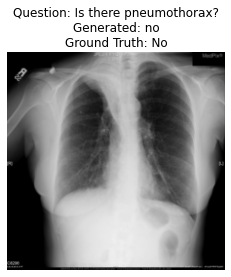

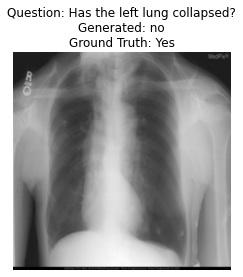

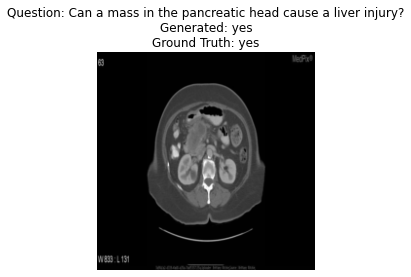

Testing:   1%|          | 1/113 [00:05<10:59,  5.89s/it]

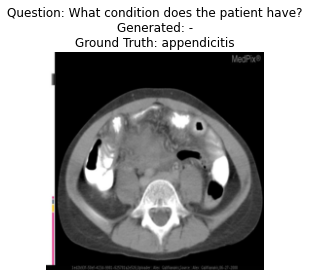

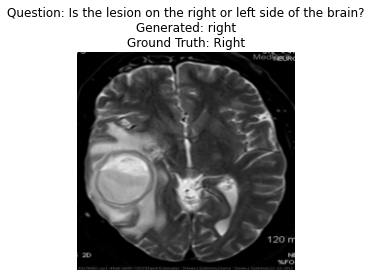

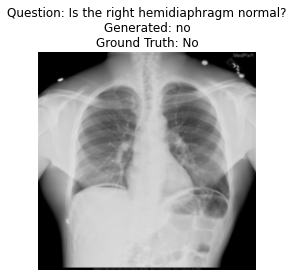

Testing:   2%|▏         | 2/113 [00:11<10:45,  5.82s/it]

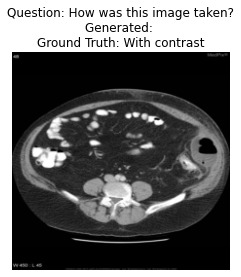

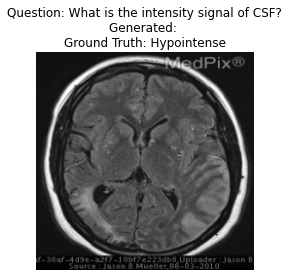

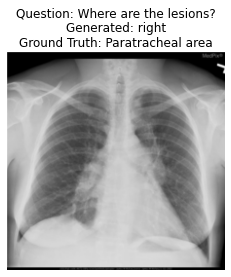

Testing: 100%|██████████| 113/113 [10:29<00:00,  5.57s/it]



Example Generated Answers vs Ground Truth:
Generated: no
Ground Truth: No
--------------------------------------------------
Generated: no
Ground Truth: Yes
--------------------------------------------------
Generated: yes
Ground Truth: yes
--------------------------------------------------
Average Loss: 1.1526
BLEU Score: 0.0093
ROUGE Scores:
  rouge1_precision: 0.2248
  rouge1_recall: 0.0791
  rouge1_f1: 0.1151
  rouge2_precision: 0.0000
  rouge2_recall: 0.0000
  rouge2_f1: 0.0000
  rougeL_precision: 0.2248
  rougeL_recall: 0.0791
  rougeL_f1: 0.1151

Closed Question Metrics (Yes/No):
  Accuracy: 0.7280
  Precision: 0.5221
  Recall: 0.4915
  F1 Score: 0.4813


c:\Anaconda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
avg_loss, bleu_score, avg_rouge, closed_accuracy, closed_precision, closed_recall, closed_f1 = test_vqa_model(
    model, test_dataloader, tokenizer, device='cuda', model_checkpoint_path='vqa_model_checkpoint.pth'
)

print(f"Average Loss: {avg_loss:.4f}")
print(f"BLEU Score: {bleu_score:.4f}")
print(f"ROUGE Scores:")
for key, value in avg_rouge.items():
    print(f"  {key}: {value:.4f}")

print("\nClosed Question Metrics (Yes/No):")
print(f"  Accuracy: {closed_accuracy:.4f}")
print(f"  Precision: {closed_precision:.4f}")
print(f"  Recall: {closed_recall:.4f}")
print(f"  F1 Score: {closed_f1:.4f}")
